In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo as pyo


# Karmbandit problem

In [2]:
class karmbandit:
    """This is the k arm bandit problem

    Attributes:
        d: number of arms
        distribution (str): distribution of rewards
        params (array): parameters of the distribution, the line i contain the parameters of the distribution of the arm i
        best_arm (int): index of the best arm
    """

    def __init__(self, d, distribution, params):
        """Init the k arm bandit problem

        Args:
            d (int): number of arms
            distribution (str): distribution of rewards
            params (array): parameters of the distribution, the line i contain the parameters of the distribution of the arm i
        """

        self.d = d
        self.distribution = distribution
        self.params = params
        if distribution == 'bernoulli':
            self.mus = params
            self.sigmas = 1/2*np.ones(d)
        if distribution == 'gaussian':
            self.mus = params[:,0]
            self.sigmas = params[:,1]
        
        self.best_arm = np.argmax(self.mus)
        self.mustar = self.mus[self.best_arm]

    def pull(self):
        """Pull the arms
        
        Returns:
            reward (float): reward of the arms
        """

        if self.distribution == 'bernoulli':
            return np.random.binomial(1,self.mus)
        if self.distribution == 'gaussian':
            return np.random.normal(self.mus, self.sigmas)

class karmpolicy:
    """This is the k arm bandit policy

    Attributes:
        d: number of armsArgs:
            index (int): index of the arm to pull
        self.muhat (array): empiric mean of the arms
        t (int): time step
        w (array): number of time an arm is played
        regrets (list) : regret at each time step
        policy (str): policy to use
        params (array): parameters of the policy
    """

    def __init__(self, karmbandit, policy, algoparams = None, prior = "uniform"):
        """Init the k arm bandit policy

        Args:
            d (int): number of arms
            policy (str): policy to use
            algoparams (array): parameters of the policy, c for ucb, epsilon for epsilon-greedy, param of the prior for thompson sampling
            prior (str): by default it is the uniform prior
        """
        # get the parameters of the k arm bandit problem
        self.karmbandit = karmbandit
        self.d = karmbandit.d
        self.bestarm = karmbandit.best_arm
        self.mus = karmbandit.mus
        self.sigmas = karmbandit.sigmas
        self.distribution = karmbandit.distribution
        self.mustar = karmbandit.mustar

        # store in the class the policy and the initial parameters
        self.policy = policy
        self.algoparams = algoparams

        # initialise the paramater of the algorithm
        self.regrets = []
        self.muhats = np.zeros(self.d)
        self.prior = prior
        # small hack to avoid division by 0 before the arm is played for the first time
        self.t = 1
        self.w = np.ones(self.d) * 10**(-8)

        if self.policy == 'epsilon-greedy':
            self.epsilon = self.algoparams[0]
        if self.policy == 'explore-commit':
            self.explore = self.algoparams[0]
        if self.policy == 'ucb':
            self.c = self.algoparams[0]
        if self.policy == 'thompson-sampling':
            if self.distribution == 'bernoulli':
                if self.prior == "beta":
                    self.alphas = self.algoparams[:0].copy()
                    self.betas = self.algoparams[:1].copy()
                if self.prior == "uniform":
                    self.alphas = np.ones(self.d)
                    self.betas = np.ones(self.d)
                if self.prior == "gaussian":
                    # In the case of a gaussian prior for bernoulli distribution we assume that the prior is uniform on R
                    # And that the bernoulli are gaussian with variance 1/4 
                    self.muhats = np.ones(self.d)/2
                    self.sigmapost = 10**8 * np.ones(self.d)
            if self.distribution == 'gaussian':
                if self.prior == "gaussian":
                    self.muhats = self.algoparams[:0].copy()
                    self.sigmapost = self.algoparams[:1].copy()
                if self.prior == "uniform":
                    self.muhats = np.zeros(self.d)
                    self.sigmapost = 10**8 * np.ones(self.d)
        if self.policy == "klucb":
            pass
    
    def reset(self):
        # initialise the paramater of the algorithm
        self.regrets = []
        self.muhats = np.zeros(self.d)
        # small hack to avoid division by 0 before the arm is played for the first time
        self.t = 1
        self.w = np.ones(self.d) * 10**(-8)

        if self.policy == 'epsilon-greedy':
            self.epsilon = self.algoparams[0]
        if self.policy == 'explore-commit':
            self.explore = self.algoparams[0]
        if self.policy == 'ucb':
            self.c = self.algoparams[0]
        if self.policy == 'thompson-sampling':
            if self.distribution == 'bernoulli':
                if self.prior == "beta":
                    self.alphas = self.algoparams[:0].copy()
                    self.betas = self.algoparams[:1].copy()
                if self.prior == "uniform":
                    self.alphas = np.ones(self.d)
                    self.betas = np.ones(self.d)
                if self.prior == "gaussian":
                    # In the case of a gaussian prior for bernoulli distribution we assume that the prior is uniform on R
                    # And that the bernoulli are gaussian with variance 1/4 
                    self.muhats = np.ones(self.d)/2
                    self.sigmapost = 10**8 * np.ones(self.d)
            if self.distribution == 'gaussian':
                if self.prior == "gaussian":
                    self.muhats = self.algoparams[:0].copy()
                    self.sigmapost = self.algoparams[:1].copy()
                if self.prior == "uniform":
                    self.muhats = np.zeros(self.d)
                    self.sigmapost = 10**8 * np.ones(self.d)
        if self.policy == "klucb":
            pass
    


    def select(self):
        """Select the arm to pull according to the algorithm policy
        
        Returns:
            index (int): index of the arm to pull
        """
        if self.policy == 'ucb':
            index = np.argmax(self.muhats + self.c * np.sqrt(2*np.log(self.t) / (self.w)))
        if self.policy == 'epsilon-greedy':
            if np.random.rand() < self.epsilon:
                index = np.random.randint(self.d)
            else:
                index = np.argmax(self.muhats)

        
        if self.policy == 'explore-commit':
            # keep exploring until every arm are explored self.explore times
            if (self.w < self.explore).any():
                index = np.argmax(self.w < self.explore)
            else:
                index = np.argmax(self.muhats)

        if self.policy == 'thompson-sampling':
            if (((self.prior == 'beta') or (self.prior == 'uniform')) and (self.distribution == 'bernoulli')):
                index = np.argmax(np.random.beta(self.alphas, self.betas))
            if self.prior == 'gaussian':
                index = np.argmax(np.random.normal(self.muhats, self.sigmapost))

        if self.policy == "klucb":
            pass
        return index

    def update(self, index, reward):
        """Update the policy
        
        Args:
            index (int): index of the arm to pull
            reward (float): reward of the arm
        """
        self.t += 1

        
        if self.w[index] < 0.5:
            # correct the hack to avoid division by 0
            self.w[index] = 1
        else:
            self.w[index] += 1
        if self.policy == 'epsilon-greedy':
            self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + reward) / self.w[index]
        if self.policy == 'explore-commit':
            self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + reward) / self.w[index]

        if self.policy == "ucb":
            self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + reward) / self.w[index]

        if self.policy == 'thompson-sampling':
            if self.distribution == 'bernoulli':
                if self.prior == 'beta' or self.prior == 'uniform':
                    self.alphas[index] += reward
                    self.betas[index] += 1 - reward
                if self.prior == 'gaussian':
                    self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + reward) / self.w[index] 
                    # I already verified the above formula
                    if self.sigmapost[index] == 10**8:
                        self.sigmapost[index] = np.sqrt(1/4)
                    else:
                        self.sigmapost[index] = np.sqrt((1/self.sigmapost[index]**2 + 1/4)**-1)
                    

            if self.distribution == 'gaussian':
                if self.prior == 'uniform':
                    self.muhats[index] = (self.muhats[index] * (self.w[index] - 1) + reward) / self.w[index]
                    if self.sigmapost[index] == 10**8:
                        self.sigmapost[index] = self.sigmas[index]
                    else:
                        self.sigmapost[index] = np.sqrt((1/self.sigmapost[index]**2 + 1/self.sigmas[index]**2)**-1)
                if self.prior == 'gaussian':
                    self.sigmapost[index] = np.sqrt((1/self.sigmapost[index] + 1/self.sigmas[index])**-1)
                    self.muhats = self.sigmapost[index]**2 * (self.muhats[index] / self.sigmapost[index]**2 + reward / self.sigmas[index]**2)
                    # The above formula is verified


        self.regrets.append(self.mustar - self.mus[index])

        
            






## Experiment 1: 10 arms, 1000 pulls




In [25]:
# test the code

d=10
T = 10000
n = 20
# create a d arm bandit problem
problem = karmbandit(d, distribution='bernoulli', params=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# initialise the algorithms

TS = karmpolicy(problem, "thompson-sampling", prior = "uniform")
TSg = karmpolicy(problem, "thompson-sampling", prior = "gaussian")
UCB = karmpolicy(problem, "ucb", algoparams=[1])
egreedy = karmpolicy(problem, "epsilon-greedy", algoparams=[d/(0.1)**2/T])
excommit = karmpolicy(problem, "explore-commit", algoparams=[np.log(T*(0.1)**2)/(0.1)**2])

TSregret = np.zeros((n,T))
TSgregret = np.zeros((n,T))
UCBregret = np.zeros((n,T))
egreedyregret = np.zeros((n,T))
excommitregret = np.zeros((n,T))

for k in range(n):
    for i in range(T):

        rewards = problem.pull()
        index = TS.select()
        TS.update(index, rewards[index])

        index = TSg.select()
        TSg.update(index, rewards[index])

        index = UCB.select()
        UCB.update(index, rewards[index])
        
        index = egreedy.select()
        egreedy.update(index, rewards[index])

        index = excommit.select()
        excommit.update(index, rewards[index])


    TSregret[k] = TS.regrets.copy()
    TSgregret[k] = TSg.regrets.copy()
    UCBregret[k] = UCB.regrets.copy() 
    egreedyregret[k] = egreedy.regrets.copy()
    excommitregret[k] = excommit.regrets.copy()

    print("TS regret: ", np.sum(TS.regrets))
    print("TSg regret: ", np.sum(TSg.regrets))
    print("UCB regret: ", np.sum(UCB.regrets))
    print("egreedy regret: ", np.sum(egreedy.regrets))
    print("excommit regret: ", np.sum(excommit.regrets))
    TS.reset()
    TSg.reset()
    UCB.reset()
    egreedy.reset()
    excommit.reset()    


TS regret:  18.7
TSg regret:  498.29999999999995
UCB regret:  326.4
egreedy regret:  443.40000000000003
excommit regret:  2074.5
TS regret:  19.400000000000002
TSg regret:  499.19999999999993
UCB regret:  343.0
egreedy regret:  455.2
excommit regret:  2074.5
TS regret:  14.899999999999999
TSg regret:  585.0
UCB regret:  338.4
egreedy regret:  489.9
excommit regret:  2074.5
TS regret:  14.399999999999999
TSg regret:  587.9
UCB regret:  328.2
egreedy regret:  554.2
excommit regret:  2074.5
TS regret:  13.9
TSg regret:  558.5999999999999
UCB regret:  361.7
egreedy regret:  494.90000000000003
excommit regret:  2074.5
TS regret:  10.3
TSg regret:  566.9
UCB regret:  365.1
egreedy regret:  443.2
excommit regret:  2074.5
TS regret:  10.7
TSg regret:  556.1
UCB regret:  363.20000000000005
egreedy regret:  491.59999999999997
excommit regret:  2074.5
TS regret:  11.6
TSg regret:  574.9
UCB regret:  337.1
egreedy regret:  584.3000000000001
excommit regret:  2074.5
TS regret:  9.9
TSg regret:  543

### Plot the results

In [18]:
def plot_regret(regrets , label = None):
    fig = plt.figure(figsize=(16, 9))

    for i in range(len(regrets)):   
        cumregret = np.cumsum(regrets[i], axis = 1)
        meancumregret = np.mean(cumregret, axis=0)
        std = np.std(cumregret, axis=0)
        T = len(meancumregret)

        plt.plot(np.arange(T),meancumregret, label=label[i])
        plt.fill_between(np.arange(T), np.maximum(meancumregret-std*1.96,np.zeros(T)), meancumregret+std*1.96  ,alpha=0.2)
    
    plt.ylim(bottom=0)
    plt.xlabel("t", fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylabel("Cumulative Regret", fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='upper left', fontsize=20)
    

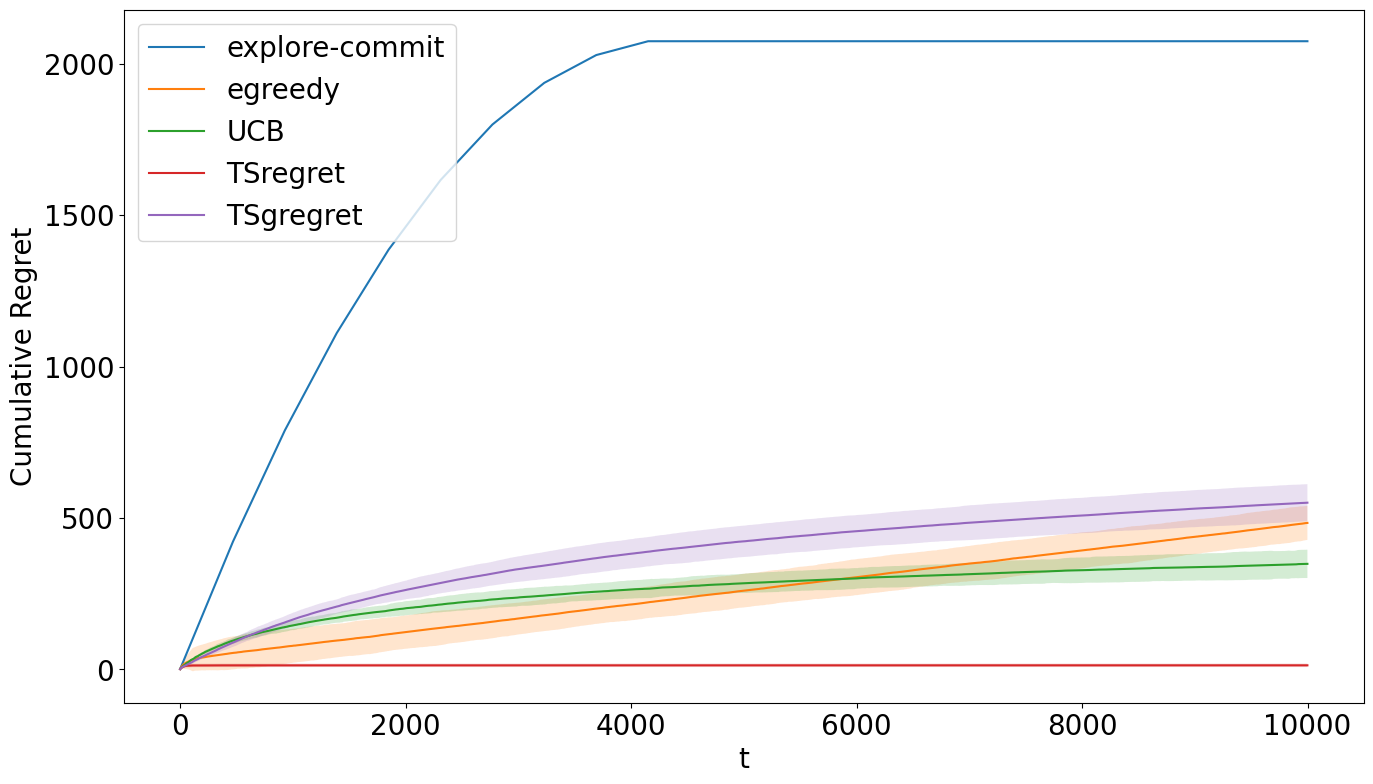

In [52]:
plot_regret([excommitregret,egreedyregret,UCBregret,TSregret,TSgregret], label = ["explore-commit","egreedy","UCB","TSregret","TSgregret"])

# Combinatorial bandit problem

In [5]:
from scipy.optimize import Bounds, LinearConstraint, minimize, NonlinearConstraint

In [25]:
class CombinatorialSet:
    """The class implements the basic methode of combinatorial set
    """
    def __init__(self, d, distribution, params):
        """Init the k arm bandit problem

        Args:
            d (int): number of arms
            distribution (str): distribution of rewards
            params (array): parameters of the distribution, the line i contain the parameters of the distribution of the arm i
        """

        self.d = d
        self.distribution = distribution
        self.params = params
        if distribution == 'bernoulli':
            self.mus = params
            self.sigmas = 1/2*np.ones_like(params)
        if distribution == 'gaussian':
            self.mus = params[...,0]
            self.sigmas = params[...,1]
        self.shape = self.mus.shape


    def pull(self):
        """Pull the arms
        
        Returns:
            reward (float): reward of the arms
        """

        if self.distribution == 'bernoulli':
            return np.random.binomial(1,self.mus)
        if self.distribution == 'gaussian':
            return np.random.normal(self.mus, self.sigmas)

class Twosets(CombinatorialSet):
    def __init__(self, d, distribution, params):
        super().__init__(d, distribution, params)
        assert d%2 == 0, "d must be even"
        self.name = "twosets"
        self.m=d//2

        self.bestdecision = np.argmax([np.sum(self.mus[:self.m]), np.sum(self.mus[self.m:])])
        self.bestdecisionset = np.concatenate([np.ones(self.m)*(1-self.bestdecision), np.ones(self.m)*self.bestdecision])
        self.rewardmax = np.sum(self.mus*self.bestdecisionset)
        self.Deltamin = (self.mus[self.m] - self.mus[0])*self.m

In [7]:
bandit = Twosets(10, 'bernoulli', np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
print(bandit.m)
print(bandit.bestdecision)
print(bandit.bestdecisionset)
print(bandit.rewardmax)

5
1
[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
4.0


In [28]:
class cbanditsAlgo:
    """This class implements the combinatorial bandit problem
    
    attributes:

    methods:
    
    """
    def __init__(self, combinatorialset, policy, algoparams = None, prior = "uniform"):
        """

        args:
            combinatorialset: the combinatorial set to be used (Mset, matching, twosets, path )
            policy: the policy to be used (TS, TSg, UCB, egreedy, excommit)
            algoparam : the parameters of the algorithm
            prior: the prior to be used (uniform, beta, gaussian) I may put this on the algo parmeters

        Attributes:
            d (int): number of arms:
            self.muhats (array): estimated mean of the arms
            t (int): time step
            w (array): number of time an arm is played
            regrets (list) : regret at each time step
            policy (str): policy to use
            algoparams (dict): parameters of the policy.
        """

        assert combinatorialset.name == "twosets", f"Only twosets are implemented for now"

        # get the parameters of the combinatorial arm bandit problem
        self.cbandits = combinatorialset
        self.d = combinatorialset.d
        self.m = combinatorialset.m
        self.shape = combinatorialset.shape
        self.name = combinatorialset.name
        

        self.bestdecisionset = combinatorialset.bestdecisionset
        self.mus = combinatorialset.mus
        self.sigmas = combinatorialset.sigmas
        self.distribution = combinatorialset.distribution
        self.rewardmax = combinatorialset.rewardmax

        # store in the class the policy and the initial parameters
        self.policy = policy
        self.algoparams = algoparams
        self.prior = prior

        self.reset()
    
    def reset(self):
        # initialise the paramater of the algorithm
        self.regrets = []
        self.muhats = np.zeros(self.d)
        # small hack to avoid division by 0 before the arm is played for the first time
        self.t = 1
        self.w = np.ones(self.shape) * 10**(-8)

        if self.policy == 'epsilon-greedy':
            self.explore = self.algoparams["explore"]
        if self.policy == 'cucb' or self.policy == 'escb':
            self.c = self.algoparams["c"]
        if self.policy == "explore-commit":
            self.explore = self.algoparams["explore"]
        if self.policy == 'thompson-sampling':
            self.bonus = self.algoparams["bonus"]
            # self.lambd = self.algoparams["lambda"] will be added later
            self.theta = np.zeros_like(self.mus)
            if self.distribution == 'bernoulli':
                if self.prior == "beta":
                    self.alphas = self.algoparams["prior"][...,0].copy()
                    self.betas = self.algoparams["prior"][...,1].copy()
                if self.prior == "uniform":
                    self.alphas = np.ones(self.shape)
                    self.betas = np.ones(self.shape)
                if self.prior == "gaussian":
                    # In the case of a gaussian prior for bernoulli distribution we assume that the prior is uniform on R
                    # And that the bernoulli are gaussian with variance 1/4 
                    self.muhats = np.ones(self.shape)/2
                    self.sigmapost = 10**8 * np.ones(self.shape)
                if self.prior == "gaussian":
                    # And that the bernoulli are gaussian with variance 1/4 
                    self.muhats = np.ones(self.shape)/2
                    self.sigmapost = 10**8 * np.ones(self.shape)
            if self.distribution == 'gaussian':
                if self.prior == "gaussian":
                    self.muhats = self.algoparams["prior"][...,0].copy()
                    self.sigmapost = self.algoparams["prior"][...,1].copy()
                if self.prior == "uniform":
                    self.muhats = np.zeros(self.shape)
                    self.sigmapost = 10**8 * np.ones(self.shape)
                if self.prior == "centered":
                    self.muhats = np.zeros(self.shape)
                    self.sigmapost = np.ones(self.shape)

        if self.policy == "thompson-sampling-adv":
            self.bonus = self.algoparams["bonus"]
            self.lambd = self.algoparams["lambda"]
            self.delta = self.algoparams["delta"]
            self.theta = np.zeros_like(self.mus)
            if self.distribution == 'bernoulli':
                if self.prior == "beta":
                    pass
                if self.prior == "uniform":
                    pass
                if self.prior == "gaussian":
                    self.rewardsum = np.zeros(self.shape)
                    self.muhats = np.zeros(self.shape)
                    self.cov = self.lambd * np.eye(self.shape)
                    self.sigmapost = np.linalg.inv(self.cov)   
            if self.distribution == 'gaussian':
                if self.prior == "gaussian":
                    # TODO Non centered case
                    self.muhats = self.algoparams["prior"][...,0].copy()
                    self.sigmapost = self.algoparams["prior"][...,1].copy()
                if self.prior == "centered":
                    self.rewardsum = np.zeros(self.shape)
                    self.muhats = np.zeros(self.shape)
                    self.cov = self.lambd * np.eye(self.d)
                    self.sigmapost = np.linalg.inv(self.cov)
        if self.policy == "escb":
            pass
    

    def select(self):
        """Select the arm to pull according to the algorithm policy
        
        Returns:
            index (int): index of the arm to pull
        """
        if self.policy == 'epsilon-greedy':
            if self.t == 1:
                if self.name == "twosets":
                    # so each decision can be played first with equal probability
                    self.bestdecision = np.random.randint(2)
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
                    return indexes
            if np.random.rand() < self.explore:
                if self.name == "twosets":
                    self.bestdecision = np.random.randint(2)
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            else:
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.muhats[:self.m]), np.sum(self.muhats[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes
        if self.policy == 'explore-commit':
            if (self.w < self.explore).any():
                if self.name == "twosets":
                    self.bestdecision = np.argmax(self.w < self.explore)
                    if self.bestdecision >= self.m:
                        self.bestdecision = 1
                    else:
                        self.bestdecision = 0
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            else:
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.muhats[:self.m]), np.sum(self.muhats[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes
        

        if self.policy == 'cucb':
            self.optimistbound = self.muhats+self.c*np.sqrt(2*np.log(self.t)/self.w)
            
            if self.name == "twosets":
                self.bestdecision = np.argmax([np.sum(self.optimistbound[:self.m]), np.sum(self.optimistbound[self.m:])])
                indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes  
        
        if self.policy == 'escb':
            self.optimistbound = self.muhats+self.c*np.sqrt(np.log(self.t)/2/self.w)/np.sqrt(self.d/2)
            if self.name == "twosets":
                self.bestdecision = np.argmax([np.sum(self.optimistbound[:self.m]), np.sum(self.optimistbound[self.m:])])
                indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes

        
        if self.policy == 'thompson-sampling':
            if (((self.prior == 'beta') or (self.prior == 'uniform')) and (self.distribution == 'bernoulli')):
                self.theta = np.random.beta(self.alphas, self.betas)
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.theta[:self.m]), np.sum(self.theta[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            if (self.prior == 'gaussian' or self.prior == 'centered' or self.prior == 'uniform') and (self.distribution == 'gaussian'):
                self.theta = np.random.normal(self.muhats, self.bonus * self.sigmapost)
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.theta[:self.m]), np.sum(self.theta[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype=int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes  

        if self.policy == 'thompson-sampling-adv':
            ### TODO
            # if self.prior == 'bernoulli' or self.prior == 'uniform':
            #     theta = np.random.beta(self.alphas, self.betas)
            #     if self.name == "twosets":
            #         self.bestdecision = np.argmax([np.sum(theta[:self.m]), np.sum(theta[self.m:])])
            #         indexes = np.concatenate([np.ones(self.m)*(1-self.bestdecision), np.ones(self.m)*self.bestdecision])
            if self.prior == 'gaussian' or self.prior == 'centered':
                error = 0
                for i in range(11):
                    try:
                        self.theta = np.random.multivariate_normal(self.muhats, self.bonus * self.d * 9 * np.log(self.t/self.delta) * self.sigmapost)
                    except np.linalg.LinAlgError as e:
                        error += 1
                        if error >= 11:
                            print("error")
                    else:
                        break
                        
                
                if self.name == "twosets":
                    self.bestdecision = np.argmax([np.sum(self.theta[:self.m]), np.sum(self.theta[self.m:])])
                    indexes = np.concatenate([np.ones(self.m,dtype= int)*(1-self.bestdecision), np.ones(self.m,dtype=int)*self.bestdecision])
            return indexes
        
    def update(self, indexes, rewards):
        """Update the policy
        
        Args:
            indexes : array: indexes of the arms to pull
            rewards : list of all the rewards of ALL arm
        """
        self.t += 1
        
        if (self.w[indexes == 1] < 0.5).any():
            # correct the hack to avoid division by 0
            self.w[(indexes == 1) & (self.w < 0.5)] = 1
            self.w[(indexes == 1) & (1-(self.w < 0.5))] += 1
        else:
            self.w[indexes==1] += 1

        if self.policy == 'epsilon-greedy':
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.w[indexes==1] - 1) + rewards[indexes == 1]) / self.w[indexes==1]
        if self.policy == 'explore-commit':
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.w[indexes==1] - 1) + rewards[indexes == 1]) / self.w[indexes==1]

        if self.policy == "cucb":
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.w[indexes==1] - 1) + rewards[indexes == 1]) / self.w[indexes==1]
        if self.policy == "escb":
            self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.w[indexes==1] - 1) + rewards[indexes == 1]) / self.w[indexes==1]

        if self.policy == 'thompson-sampling':
            if self.distribution == 'bernoulli':
                if self.prior == 'beta' or self.prior == 'uniform':
                    self.alphas[indexes==1] += rewards[indexes == 1]
                    self.betas[indexes==1] += 1 - rewards[indexes == 1]
                if self.prior == 'gaussian' or self.prior == 'centered':
                    self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.w[indexes==1] - 1) + rewards[indexes == 1]) / self.w[indexes==1] 
                    # I already verified the above formula
                    if (self.sigmapost[indexes==1] == 10**8).any():
                        self.sigmapost[(indexes==1) & (self.sigmapost == 10**8)] = np.sqrt(1/4)
                        self.sigmapost[(indexes==1) & (1-(self.sigmapost == 10**8))] = np.sqrt((1/self.sigmapost[(indexes==1) & (1-(self.sigmapost == 10**8))]**2 + 1/4)**-1) 
                    else:
                        self.sigmapost[indexes==1] = np.sqrt((1/self.sigmapost[indexes==1]**2 + 1/4)**-1) 

            if self.distribution == 'gaussian':
                if self.prior == 'uniform':
                    self.muhats[indexes==1] = (self.muhats[indexes==1] * (self.w[indexes==1] - 1) + rewards[indexes == 1]) / self.w[indexes==1]
                    if (self.sigmapost[indexes==1] == 10**8).any():
                        self.sigmapost[(indexes==1) & (self.sigmapost == 10**8)] = self.sigmas[(indexes==1) & (self.sigmapost == 10**8)]
                        self.sigmapost[(indexes==1) & (1-(self.sigmapost == 10**8))] = np.sqrt((1/self.sigmapost[(indexes==1) & (1-(self.sigmapost == 10**8))]**2 + 1/self.sigmas[(indexes==1) & (1-(self.sigmapost == 10**8))]**2)**-1)
                    else:
                        self.sigmapost[indexes==1] = np.sqrt((1/self.sigmapost[indexes==1]**2 + 1/self.sigmas[indexes==1]**2)**-1)
                if self.prior == 'gaussian' or self.prior == 'centered':
                    self.sigmapost[indexes==1] = np.sqrt((1/self.sigmapost[indexes==1] + 1/self.sigmas[indexes==1])**-1)
                    self.muhats[indexes ==1] = self.sigmapost[indexes==1]**2 * (self.muhats[indexes==1] / self.sigmapost[indexes==1]**2 + rewards[indexes == 1] / self.sigmas[indexes==1]**2)
                    
        
        if self.policy == 'thompson-sampling-adv':
            ### TODO: Make it online so that we dont have to compute the inverse all the time woodbury etc
            ### TODO: implement the update for bernoulli adverserial case
            ### TODO implement the non centered case
            if self.distribution == 'bernoulli':
            #     if self.prior == 'beta' or self.prior == 'uniform':
            #         self.alphas[indexes==1] += rewards[indexes == 1]
            #         self.betas[indexes==1] += 1 - rewards[indexes == 1]
                if self.prior == 'gaussian':
                    self.rewardsum += indexes * np.sum(rewards[indexes == 1])
                    self.cov += np.outer(indexes,indexes)
                    self.sigmapost = np.linalg.inv(self.cov)
                    self.muhats = self.sigmapost@self.rewardsum
            if self.distribution == 'gaussian':
                # TODO expend it to other cases
                    self.rewardsum += indexes * np.sum(rewards[indexes == 1])
                    self.cov += np.outer(indexes,indexes)
                    self.sigmapost = np.linalg.inv(self.cov)
                    self.muhats = self.sigmapost@self.rewardsum

        self.regrets.append(self.rewardmax - np.sum(self.mus[indexes==1]))



In [138]:
mat = np.random.randn(10)
print(mat)
index = np.concatenate((np.ones(5,dtype=int),np.zeros(5,dtype=int)))
select = mat[index]
print(select)




[-1.17999887 -1.47252386  0.64956538  1.07258198  2.17169502  1.4973896
  0.81995919 -0.17607891  0.92162183 -1.11376585]
[-1.47252386 -1.47252386 -1.47252386 -1.47252386 -1.47252386 -1.17999887
 -1.17999887 -1.17999887 -1.17999887 -1.17999887]


In [139]:
a = np.array([[0,1] if i < d//2 else [1,1] for i in range(d)])
param = {"bonus" : 1,
         "lambda" : 1,
}
v= a[...,0]
print(v, a.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (100, 2)


## TEST the code for the combinatorial bandit problem

In [29]:
# test the code

d = 10
T = 1000
N = 2000
# create a d arm bandit problem
problem = Twosets(d,distribution='gaussian', params=np.array([[0.9,1] if i < d//2 else [1,1] for i in range(d)]))

# initialise the algorithms

params = {"bonus" : 1,
         "T" : T
}

paramsdict = {}

cTS = cbanditsAlgo(problem, "thompson-sampling",algoparams =  params, prior = "uniform")
paramsdict["cTS"] = params

cTSg = cbanditsAlgo(problem, "thompson-sampling",algoparams = params, prior = "centered")
paramsdict["cTSg"] = params

params = {"bonus" : 1,
         "lambda" : 1,
         "delta" : 1/T,
         "T" : T
}

cTSadv = cbanditsAlgo(problem, "thompson-sampling-adv",algoparams = params, prior = "centered")
paramsdict["cTSadv"] = params

params = {"c" : 1, "T" : T}
cUCB = cbanditsAlgo(problem, "cucb", algoparams={'c' : 1})
paramsdict["cUCB"] = params
escb = cbanditsAlgo(problem, "escb", algoparams={'c' : 1})
paramsdict["escb"] = params

params = {"explore" : 2/(0.1*d/2)**2/T,  "T" : T}
egreedy = cbanditsAlgo(problem, "epsilon-greedy", algoparams={"explore" : 2/(0.1*d/2)**2/T})
paramsdict["egreedy"] = params
excommit = cbanditsAlgo(problem, "explore-commit", algoparams={"explore" : np.log(T*(0.1*d/2)**2)/(0.1*d/2)**2 })
paramsdict["excommit"] = params

cTSregrets = np.zeros((N,T))
cTSgregrets = np.zeros((N,T))
cTSadvregrets = np.zeros((N,T))
cUCBregrets = np.zeros((N,T))
escbregrets = np.zeros((N,T))
egreedyregrets = np.zeros((N,T))
excommitregrets = np.zeros((N,T))

for k in range(N):
    print(f"iteration {k}")
    for i in range(T):

        rewards = problem.pull()
        indexes = cTS.select()
        cTS.update(indexes, rewards)

        indexes = cTSg.select()
        cTSg.update(indexes, rewards)

        indexes = cTSadv.select()
        cTSadv.update(indexes, rewards)

        indexes = cUCB.select()
        cUCB.update(indexes, rewards)

        indexes = escb.select()
        escb.update(indexes, rewards)
        
        indexes = egreedy.select()
        egreedy.update(indexes, rewards)

        indexes = excommit.select()
        excommit.update(indexes, rewards)


    cTSregrets[k] = cTS.regrets.copy()
    cTSgregrets[k] = cTSg.regrets.copy()
    cTSadvregrets[k] = cTSadv.regrets.copy()
    cUCBregrets[k] = cUCB.regrets.copy() 
    escbregrets[k] = escb.regrets.copy()
    egreedyregrets[k] = egreedy.regrets.copy()
    excommitregrets[k] = excommit.regrets.copy()

    print("cTS regret: ", np.sum(cTS.regrets))
    print("cTSg regret: ", np.sum(cTSg.regrets))
    print("cTSadv regret: ", np.sum(cTSadv.regrets))
    print("cUCB regret: ", np.sum(cUCB.regrets))
    print("escb regret: ", np.sum(escb.regrets))
    print("egreedy regret: ", np.sum(egreedy.regrets))
    print("excommit regret: ", np.sum(excommit.regrets))
    cTS.reset()
    cTSg.reset()
    cTSadv.reset()
    cUCB.reset()
    escb.reset()
    egreedy.reset()
    excommit.reset()    

regretsdict =  {"cTS" : cTSregrets,
         "cTSg" : cTSgregrets,
         "cTSadv" : cTSadvregrets,
         "cUCB" : cUCBregrets,
         "escb" : escbregrets,
         "egreedy" : egreedyregrets,
         "excommit" : excommitregrets
         }

iteration 0
cTS regret:  19.0
cTSg regret:  1.0
cTSadv regret:  235.0
cUCB regret:  148.0
escb regret:  46.0
egreedy regret:  497.0
excommit regret:  54.5
iteration 1
cTS regret:  82.0
cTSg regret:  0.0
cTSadv regret:  227.0
cUCB regret:  130.0
escb regret:  20.0
egreedy regret:  2.0
excommit regret:  11.5
iteration 2
cTS regret:  31.5
cTSg regret:  500.0
cTSadv regret:  247.0
cUCB regret:  116.5
escb regret:  17.5
egreedy regret:  8.0
excommit regret:  479.5
iteration 3
cTS regret:  100.0
cTSg regret:  499.5
cTSadv regret:  229.0
cUCB regret:  128.0
escb regret:  8.0
egreedy regret:  2.5
excommit regret:  486.5
iteration 4
cTS regret:  53.0
cTSg regret:  0.0
cTSadv regret:  247.0
cUCB regret:  151.5
escb regret:  29.5
egreedy regret:  499.0
excommit regret:  16.5
iteration 5
cTS regret:  63.0
cTSg regret:  500.0
cTSadv regret:  238.5
cUCB regret:  94.0
escb regret:  1.5
egreedy regret:  4.0
excommit regret:  11.5
iteration 6
cTS regret:  8.5
cTSg regret:  499.5
cTSadv regret:  229.5
c

KeyError: 'ecommit'

(20, 10000)

In [43]:
print(cTSadv.bonus)
print(cTSadv.sigmapost)

5.0
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [53]:
import utilities
import importlib
importlib.reload(utilities)

<module 'utilities' from '/home/zhang/Bureau/cbandits/utilities.py'>

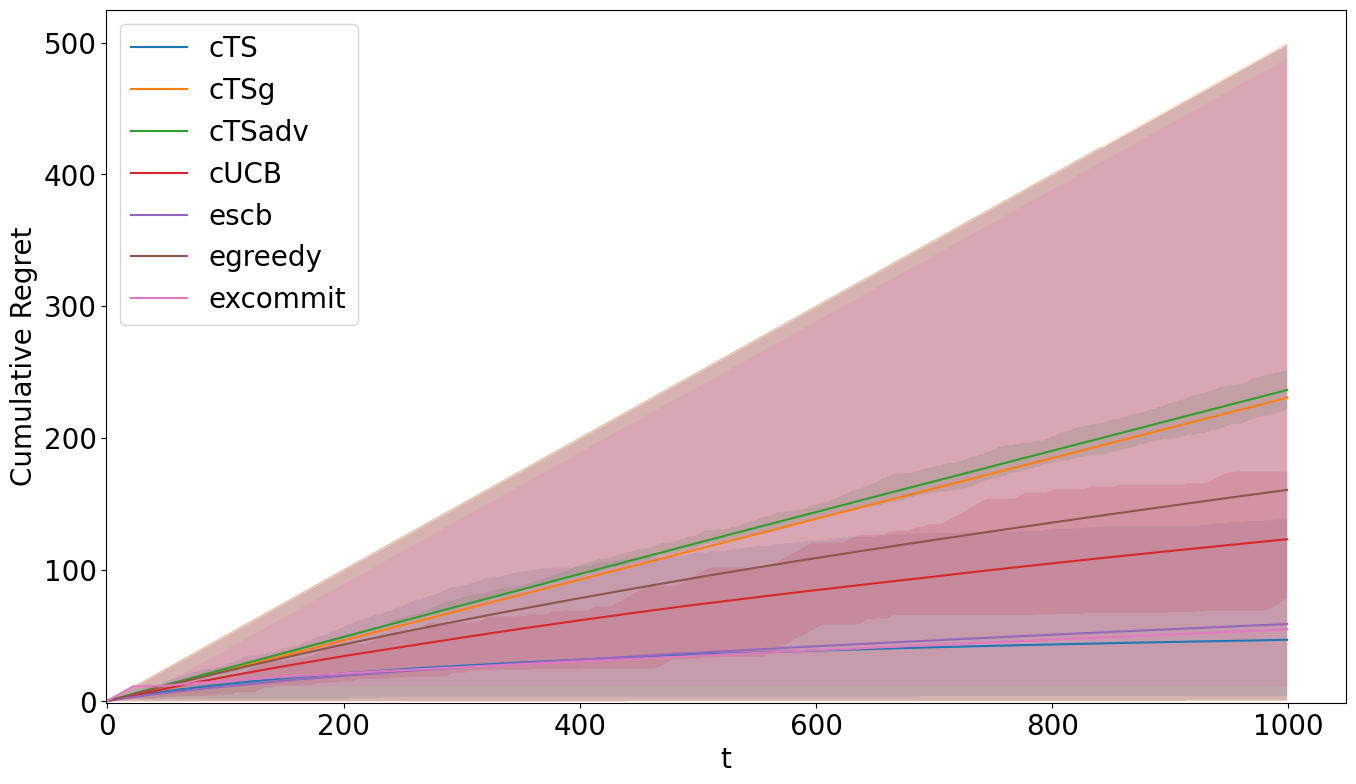

In [54]:
utilities.plot_regret(regretsdict,save = True, paramsdict = paramsdict, banditenv=problem)